In [1]:
!pip install torch torchvision timm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-4-afaf989965c2>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_location=device))


Model Performance:
Test Loss: 1.3327
Accuracy: 76.11%
AUC: 0.95
Confusion Matrix:
[[344   8   6  61  21]
 [  0 434   6   0   0]
 [  0  86 354   0   0]
 [ 79   0   0 350  11]
 [ 36  34 128  52 200]]
Inference Time: 15.32 seconds


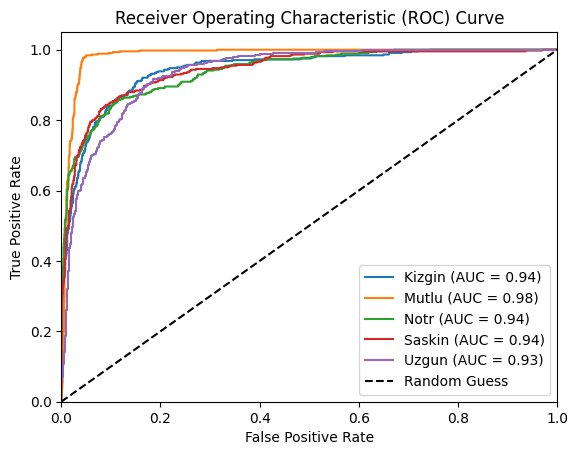

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import time
from timm import create_model

# GPU kullanımı
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # GPU performansı için optimize

# Veriyi hazırlama
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Görüntüleri boyutlandırma
    transforms.ToTensor(),          # Tenzöre dönüştürme
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalizasyon
])

# Veri setlerini yükleme
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Dataset/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Modeli oluşturma ve eğitilmiş ağırlıkları yükleme
model_save_path = '/content/drive/MyDrive/tinyvit_model.pth'
model = create_model('vit_tiny_patch16_224', pretrained=False, num_classes=len(test_dataset.classes))
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.to(device)
model.eval()

# Test Loss ve ROC eğrisi için fonksiyon
def evaluate_vit_model(model, test_loader):
    model.eval()  # Modeli değerlendirme moduna al
    test_loss = 0.0
    total = 0
    correct = 0

    all_labels = []
    all_predictions = []
    all_probabilities = []

    start_time = time.time()

    criterion = torch.nn.CrossEntropyLoss()  # Loss fonksiyonu

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    # Performans metrikleri
    accuracy = correct / total
    all_probabilities = np.array(all_probabilities)
    auc_score = roc_auc_score(all_labels, all_probabilities, multi_class='ovr')

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)

    end_time = time.time()

    # Sonuçları yazdırma
    print("Model Performance:")
    print(f"Test Loss: {test_loss / len(test_loader):.4f}")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"AUC: {auc_score:.2f}")
    print("Confusion Matrix:")
    print(cm)
    print(f"Inference Time: {end_time - start_time:.2f} seconds")

    # ROC eğrisi çizimi
    fpr = {}
    tpr = {}
    roc_auc = {}
    class_names = test_loader.dataset.classes  # Sınıf adları
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, all_probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i, class_name in enumerate(class_names):
        plt.plot(fpr[i], tpr[i], label=f"{class_name} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Modeli değerlendirme
evaluate_vit_model(model, test_loader)
